## Amino acid sequence of protein domain - class prediction

### Problem description
This directory contains data to train a model to predict the function of protein domains, based on the PFam dataset.

Domains are functional sub-parts of proteins; much like images in ImageNet are pre segmented to contain exactly one object class, this data is presegmented to contain exactly and only one domain.

The purpose of the dataset is to repose the PFam seed dataset as a multiclass classification machine learning task.

The task is: given the amino acid sequence of the protein domain, predict which class it belongs to. There are about 1 million training examples, and 18,000 output classes.

### Data structure
This data is more completely described by the publication "Can Deep Learning Classify the Protein Universe", Bileschi et al.

#### Data split and layout
The approach used to partition the data into training/dev/testing folds is a random split.

Training data should be used to train your models.
Dev (development) data should be used in a close validation loop (maybe for hyperparameter tuning or model validation).
Test data should be reserved for much less frequent evaluations - this helps avoid overfitting on your test data, as it should only be used infrequently.
#### File content
Each fold (train, dev, test) has a number of files in it. Each of those files contains csv on each line, which has the following fields:

sequence: HWLQMRDSMNTYNNMVNRCFATCIRSFQEKKVNAEEMDCTKRCVTKFVGYSQRVALRFAE 
family_accession: PF02953.15
sequence_name: C5K6N5_PERM5/28-87
aligned_sequence: ....HWLQMRDSMNTYNNMVNRCFATCI...........RS.F....QEKKVNAEE.....MDCT....KRCVTKFVGYSQRVALRFAE 
family_id: zf-Tim10_DDP
Description of fields: - sequence: These are usually the input features to your model. Amino acid sequence for this domain. There are 20 very common amino acids (frequency > 1,000,000), and 4 amino acids that are quite uncommon: X, U, B, O, Z. - family_accession: These are usually the labels for your model. Accession number in form PFxxxxx.y (Pfam), where xxxxx is the family accession, and y is the version number. Some values of y are greater than ten, and so 'y' has two digits. - family_id: One word name for family. - sequence_name: Sequence name, in the form "$uniprot_accession_id/$start_index-$end_index". - aligned_sequence: Contains a single sequence from the multiple sequence alignment (with the rest of the members of the family in seed, with gaps retained.

Generally, the family_accession field is the label, and the sequence (or aligned sequence) is the training feature.

This sequence corresponds to a domain, not a full protein.

The contents of these fields is the same as to the data provided in Stockholm format by PFam at ftp://ftp.ebi.ac.uk/pub/databases/Pfam/releases/Pfam32.0/Pfam-A.seed.gz

[1] Eddy, Sean R. "Accelerated profile HMM searches." PLoS computational biology 7.10 (2011): e1002195.

#### Reference: https://www.kaggle.com/googleai/pfam-seed-random-split

### Machine Learning Task:
* Multiclass classification problem for amino acid sequence of the protein domain, predict which class it belongs to.
* Classes can be extracted from family_accession field
* Training data can be obtained from sequence. These are usually the input features to your model

## **SOLUTION**:

## Importing required lib's

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)
from os import listdir
from tqdm import tqdm
#Supress scientific notation
pd.options.display.float_format = '{:20,.2f}'.format

Using TensorFlow backend.


### Defining Pretty Table

In [2]:
from prettytable import PrettyTable
model_pretty_table = PrettyTable()
model_pretty_table.field_names = ["Model","Test Score","Test Accuracy"]

### Combining all training files to one file, the same for dev and test datasets
* Data Source: https://www.kaggle.com/googleai/pfam-seed-random-split

In [3]:
'''
dir_ = "random_split/train"
filepaths = [f for f in listdir(dir_)] # if f.endswith('.csv')]
pd.concat(map(pd.read_csv, [dir_ + '/' + s for s in filepaths])).to_csv("train.csv", index=False)

dir_ = "random_split/dev"
filepaths = [f for f in listdir(dir_)] # if f.endswith('.csv')]
pd.concat(map(pd.read_csv, [dir_ + '/' + s for s in filepaths])).to_csv("dev.csv", index=False)

dir_ = "random_split/test"
filepaths = [f for f in listdir(dir_)] # if f.endswith('.csv')]
pd.concat(map(pd.read_csv, [dir_ + '/' + s for s in filepaths])).to_csv("test.csv", index=False)
'''

'\ndir_ = "random_split/train"\nfilepaths = [f for f in listdir(dir_)] # if f.endswith(\'.csv\')]\npd.concat(map(pd.read_csv, [dir_ + \'/\' + s for s in filepaths])).to_csv("train.csv", index=False)\n\ndir_ = "random_split/dev"\nfilepaths = [f for f in listdir(dir_)] # if f.endswith(\'.csv\')]\npd.concat(map(pd.read_csv, [dir_ + \'/\' + s for s in filepaths])).to_csv("dev.csv", index=False)\n\ndir_ = "random_split/test"\nfilepaths = [f for f in listdir(dir_)] # if f.endswith(\'.csv\')]\npd.concat(map(pd.read_csv, [dir_ + \'/\' + s for s in filepaths])).to_csv("test.csv", index=False)\n'

### Loading datasets

In [4]:
df_train = pd.read_csv("../input/train.csv")[0:100000]
df_dev = pd.read_csv("../input/dev.csv")[0:10000]
df_test = pd.read_csv("../input/test.csv")[0:10000]
print("df_train: ", df_train.shape)
print("df_dev  : ", df_dev.shape)
print("df_test : ", df_test.shape)

df_train:  (100000, 5)
df_dev  :  (10000, 5)
df_test :  (10000, 5)


### EDA

#### number of classes in train, dev, test datasets

In [5]:
print("Unique number of classes across train set: ", len(np.unique(df_train.family_accession)))
print("Unique number of classes across dev set  : ", len(np.unique(df_dev.family_accession)))
print("Unique number of classes across test set : ", len(np.unique(df_test.family_accession)))
print("Unique number of classes across all sets : ", len (np.union1d( np.union1d(df_train.family_accession, df_dev.family_accession) , df_test.family_accession) ))
number_of_unique_classes = len (np.union1d( np.union1d(df_train.family_accession, df_dev.family_accession) , df_test.family_accession) )

Unique number of classes across train set:  13405
Unique number of classes across dev set  :  4921
Unique number of classes across test set :  4934
Unique number of classes across all sets :  13666


#### common number of classes across sets

In [6]:
classes = np.intersect1d( np.intersect1d(df_train.family_accession, df_dev.family_accession) , df_test.family_accession)
number_of_unique_classes = len (classes)
number_of_unique_classes

2884

In [7]:
df_train = df_train.loc[df_train.family_accession.isin(classes)].reset_index()
df_dev   = df_dev  .loc[df_dev  .family_accession.isin(classes)].reset_index()
df_test  = df_test .loc[df_test .family_accession.isin(classes)].reset_index()
print("df_train: ", df_train.shape)
print("df_dev  : ", df_dev.shape)
print("df_test : ", df_test.shape)

df_train:  (58223, 6)
df_dev  :  (7341, 6)
df_test :  (7352, 6)


In [8]:
'''
import seaborn as sns
import matplotlib.pyplot as plt
a4_dims = (20, 4)
sns.set(style="darkgrid")
ax = sns.countplot(x="family_accession", data=df_train)
plt.show()
'''

'\nimport seaborn as sns\nimport matplotlib.pyplot as plt\na4_dims = (20, 4)\nsns.set(style="darkgrid")\nax = sns.countplot(x="family_accession", data=df_train)\nplt.show()\n'

In [9]:
df_train.head()

,index,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,0,GMC_oxred_C,A4WZS5_RHOS5/416-539,PF05199.13,PHPE.SRIRLST.RRDAHGMP.....IP.RIESRLGP............,PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAIL...
1,3,Asp_decarbox,X2GQZ4_9BACI/1-115,PF02261.16,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...
2,4,Filamin,A7SQM3_NEMVE/342-439,PF00630.19,TACPKQ.CTA....RGLG.............LK.AAPVT.QPT..R...,TACPKQCTARGLGLKAAPVTQPTRFVVILNDCHGQPLGRSEGELEV...
3,6,GGACT,A0A086WQ80_9VIBR/5-113,PF06094.12,LFVY...GTLRQG..ESNH.N.F.L.AD.....S...Q...........,LFVYGTLRQGESNHNFLADSQCLGHFETPPHYALYDLGTYPAVIEG...
4,8,His_kinase,Q47E94_DECAR/372-450,PF06580.13,SE.I..KLLHAQVNPHFLFNALNTL......S....AV...I.......,SEIKLLHAQVNPHFLFNALNTLSAVIRRDPEKACHLVLNLSTFFRK...


### Length of sequences

In [10]:
'''
%timeit -n 100 df.col1.str.len().max()
100 loops, best of 3: 11.7 ms per loop

%timeit -n 100 df.col1.map(lambda x: len(x)).max()
100 loops, best of 3: 16.4 ms per loop

%timeit -n 100 df.col1.map(len).max()
100 loops, best of 3: 10.1 ms per loop
'''
#%time df_train.sequence.map(len).plot()

'\n%timeit -n 100 df.col1.str.len().max()\n100 loops, best of 3: 11.7 ms per loop\n\n%timeit -n 100 df.col1.map(lambda x: len(x)).max()\n100 loops, best of 3: 16.4 ms per loop\n\n%timeit -n 100 df.col1.map(len).max()\n100 loops, best of 3: 10.1 ms per loop\n'

In [11]:
#### Train Sequence length percentiles
pd.DataFrame(df_train.sequence.map(len)).describe(include = 'all', percentiles = [.1, .2, .3, .4, .5, .6, .7, .8, .9])

,sequence
count,"58,223.00"
mean,148.71
std,113.84
min,6.00
10%,51.00
20%,67.00
30%,80.00
40%,95.00
50%,113.00
60%,135.00


In [12]:
#### Dev Sequence length percentiles
pd.DataFrame(df_dev.sequence.map(len)).describe(include = 'all', percentiles = [.1, .2, .3, .4, .5, .6, .7, .8, .9])

,sequence
count,"7,341.00"
mean,150.38
std,114.87
min,10.00
10%,52.00
20%,67.00
30%,81.00
40%,97.00
50%,115.00
60%,135.00


In [13]:
#### Test Sequence length percentiles
pd.DataFrame(df_test.sequence.map(len)).describe(include = 'all', percentiles = [.1, .2, .3, .4, .5, .6, .7, .8, .9])

,sequence
count,"7,352.00"
mean,149.89
std,114.14
min,10.00
10%,51.00
20%,67.00
30%,80.00
40%,96.00
50%,115.00
60%,138.00


In [14]:
'''
word = 'CatBatSatFatOr'
s_= ''
for i in range(0, len(word), 1):
    s_ = s_ + ' ' + word[i]
s_
'''

"\nword = 'CatBatSatFatOr'\ns_= ''\nfor i in range(0, len(word), 1):\n    s_ = s_ + ' ' + word[i]\ns_\n"

In [15]:
'''
## Selecting first 5k records for processing as a sample
num_of_points=5000
data = final_text_processed[0:num_of_points]

print("Min and max time values for sample data :")
print("Time min:", data['Time'].min())
print("Time max:", data['Time'].max())

X = data['CleanedText']
Y = np.array([1 if x=='positive' else 0 for x in data['Score']])
XYTime=data['Time']
print("X Shape : ",X.shape, " X Ndim: ",X.ndim)
print("Y Shape : ",Y.shape, " Y Ndim: ",Y.ndim)
#print(X); print(Y)
from scipy import stats
stats.describe(Y)

## Splitting dataset into train and test with 70:30 ratio**
# Train to test ratio is 70:30
boundry=int(num_of_points*0.7)
print("Boundry: ", boundry)
# split the data set into train and test based in time and not random splitting
x_train = X[:boundry]; x_test = X[boundry:]
Y_train = Y[:boundry]; Y_test = Y[boundry:]
XYTime_train = XYTime[:boundry]; XYTime_test = XYTime[boundry:]

#x_train, x_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size=0.3, random_state=0)
print("x train Shape : ",x_train.shape, " x Ndim: ",x_train.ndim); print("y train Shape : ",Y_train.shape, " y Ndim: ",Y_train.ndim)
print("x test Shape : ",x_test.shape, " x Ndim: ",x_test.ndim); print("y test Shape : ",Y_test.shape, " y Ndim: ",Y_test.ndim)

print("\nMin and max time values for time for both train and test :")
print("Train Time min:", XYTime_train.min())
print("Train Time max:", XYTime_train.max())
print("Test Time min:", XYTime_test.min())
print("Test Time max:", XYTime_test.max())
'''

'\n## Selecting first 5k records for processing as a sample\nnum_of_points=5000\ndata = final_text_processed[0:num_of_points]\n\nprint("Min and max time values for sample data :")\nprint("Time min:", data[\'Time\'].min())\nprint("Time max:", data[\'Time\'].max())\n\nX = data[\'CleanedText\']\nY = np.array([1 if x==\'positive\' else 0 for x in data[\'Score\']])\nXYTime=data[\'Time\']\nprint("X Shape : ",X.shape, " X Ndim: ",X.ndim)\nprint("Y Shape : ",Y.shape, " Y Ndim: ",Y.ndim)\n#print(X); print(Y)\nfrom scipy import stats\nstats.describe(Y)\n\n## Splitting dataset into train and test with 70:30 ratio**\n# Train to test ratio is 70:30\nboundry=int(num_of_points*0.7)\nprint("Boundry: ", boundry)\n# split the data set into train and test based in time and not random splitting\nx_train = X[:boundry]; x_test = X[boundry:]\nY_train = Y[:boundry]; Y_test = Y[boundry:]\nXYTime_train = XYTime[:boundry]; XYTime_test = XYTime[boundry:]\n\n#x_train, x_test, y_train, y_test = cross_validation.tra


## **Preprocessing **

**Lets define functions here**

In [16]:
def seq2_space_seperated_chars(word):
    '''
    Wequence to space seperated characters. Example: 'ABCDEFG' to ' A B C D E F G'
    '''
    s_= ''
    for i in range(0, len(word), 1):
        s_ = s_ + ' ' + word[i]
    return s_

#seq2_space_seperated_chars(df_train.sequence[2])

def top_freq_features(df, n):
    return df[:n]





In [17]:
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(fig, x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    plt.show()
    
def compile_execute_model():
    """Compile, execute and evaluate the model. Get "Categorical Crossentropy Loss" vs "epocs" plot"""
    print("Model Summary:")
    model.summary()
    print("Model Compilation:")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print("Model Execution:")
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_cv, y_cv))
    score = model.evaluate(X_test, y_test, verbose=0) 
    print('cv score:', score[0]) 
    print('cv accuracy:', score[1])
    
    model_pretty_table.add_row([model_name, round(score[0]*100,2), round(score[1]*100,2)])
    
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

    # list of epoch numbers
    x = list(range(1,nb_epoch+1))

    vy = history.history['val_loss']
    ty = history.history['loss']
    plt_dynamic(fig, x, vy, ty, ax)   

### Convert seperate genes with space in sequences

In [18]:
#%time x_train = df_train.sequence.apply((lambda x: seq2_space_seperated_chars(x)))
#%time x_cv    = df_dev.sequence.apply((lambda x: seq2_space_seperated_chars(x)))
#%time x_test  = df_test.sequence.apply((lambda x: seq2_space_seperated_chars(x)))

%time x_train = df_train.sequence.apply(seq2_space_seperated_chars)
%time x_cv    = df_dev.sequence.apply(seq2_space_seperated_chars)
%time x_test  = df_test.sequence.apply(seq2_space_seperated_chars)

values   = np.arange(0,len(df_train.family_accession.unique()),1)
keys = df_train.family_accession.unique()
%time dict_class = dict(zip(keys, values))

%time y_train = df_train.family_accession.apply(lambda x: dict_class[x])
%time y_cv    = df_dev.family_accession.apply(lambda x: dict_class[x])
%time y_test  = df_test.family_accession.apply(lambda x: dict_class[x])

CPU times: user 1.63 s, sys: 0 ns, total: 1.63 s
Wall time: 1.63 s
CPU times: user 204 ms, sys: 0 ns, total: 204 ms
Wall time: 200 ms
CPU times: user 204 ms, sys: 0 ns, total: 204 ms
Wall time: 203 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 452 µs
CPU times: user 180 ms, sys: 0 ns, total: 180 ms
Wall time: 179 ms
CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 23.7 ms
CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 24.1 ms


In [19]:
x_train[0:5]

0     P H P E S R I R L S T R R D A H G M P I P R I...
1     M L R M M M N S K I H R A T V T E A D L N Y V...
2     T A C P K Q C T A R G L G L K A A P V T Q P T...
3     L F V Y G T L R Q G E S N H N F L A D S Q C L...
4     S E I K L L H A Q V N P H F L F N A L N T L S...
Name: sequence, dtype: object

In [20]:
'''
# here we are having a class number for each image
print("Number of unique classes :", number_of_unique_classes)
print("Before converting the output into a vector : ",y_train[0])
# lets convert this into a 10 dimensional vector
# ex: consider an image is 5 convert it into 5 => [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
# this conversion needed for MLPs 

from keras.utils import np_utils 
#Y_train = np_utils.to_categorical(y_train, number_of_unique_classes) 
Y_cv    = np_utils.to_categorical(y_cv, number_of_unique_classes) 
Y_test  = np_utils.to_categorical(y_test, number_of_unique_classes)

print("After converting the output into a vector : ",Y_train[0])
'''

'\n# here we are having a class number for each image\nprint("Number of unique classes :", number_of_unique_classes)\nprint("Before converting the output into a vector : ",y_train[0])\n# lets convert this into a 10 dimensional vector\n# ex: consider an image is 5 convert it into 5 => [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]\n# this conversion needed for MLPs \n\nfrom keras.utils import np_utils \n#Y_train = np_utils.to_categorical(y_train, number_of_unique_classes) \nY_cv    = np_utils.to_categorical(y_cv, number_of_unique_classes) \nY_test  = np_utils.to_categorical(y_test, number_of_unique_classes)\n\nprint("After converting the output into a vector : ",Y_train[0])\n'

In [21]:
'''
from keras.utils import np_utils
def get_categorical(y_train, number_of_unique_classes):
    Y_train = []
    for class_ in y_train:
        class__ = np_utils.to_categorical(class_, number_of_unique_classes) 
        Y_train.append(class__)
    Y_train = np.array(Y_train)
    return Y_train

%time Y_train = get_categorical(y_train, number_of_unique_classes)
%time Y_cv    = get_categorical(y_cv, number_of_unique_classes)
%time Y_test  = get_categorical(y_test, number_of_unique_classes)
'''

'\nfrom keras.utils import np_utils\ndef get_categorical(y_train, number_of_unique_classes):\n    Y_train = []\n    for class_ in y_train:\n        class__ = np_utils.to_categorical(class_, number_of_unique_classes) \n        Y_train.append(class__)\n    Y_train = np.array(Y_train)\n    return Y_train\n\n%time Y_train = get_categorical(y_train, number_of_unique_classes)\n%time Y_cv    = get_categorical(y_cv, number_of_unique_classes)\n%time Y_test  = get_categorical(y_test, number_of_unique_classes)\n'

https://stackoverflow.com/questions/52476191/what-does-initial-epoch-in-keras-mean

In [22]:
y_train.shape

(58223,)

In [23]:
'''
a = []
a.append([1,2,3])
a.append([1,2,3])
np.array(a)
'''

'\na = []\na.append([1,2,3])\na.append([1,2,3])\nnp.array(a)\n'

In [24]:
#df_class = pd.DataFrame(y_train.unique()); df_class.columns = ['class']
#def get_class_index(class_):
#    return np.where(df_class['class']=='PF05750.11')[0][0]

**Lets use BoW for word counts**

In [25]:
#BoW
feature_transform = 'BoW'

#bow_scalar = CountVectorizer() #in scikit-learn
#ValueError: empty vocabulary; perhaps the documents only contain stop words
# https://stackoverflow.com/questions/43601358/empty-vocabulary-for-single-letter-by-countvectorizer
#The default token_pattern regexp in CountVectorizer selects words which have atleast 2 chars
#From the source code of CountVectorizer it is r"(?u)\b\w\w+\b
#Change it to r"(?u)\b\w+\b to include 1 letter words.

bow_scalar = CountVectorizer(token_pattern = r"(?u)\b\w+\b")
%time bow_scalar.fit(x_train.values)

%time final_counts = bow_scalar.transform(x_train.values).toarray()
%time final_counts = final_counts.sum(axis=0)
final_counts.shape

CPU times: user 4.37 s, sys: 8 ms, total: 4.38 s
Wall time: 4.39 s
CPU times: user 4.53 s, sys: 0 ns, total: 4.53 s
Wall time: 4.53 s
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.48 ms


(22,)

In [26]:
#final_counts

**Creating tabular format as feature against frequency in descending order**

In [27]:
df = pd.DataFrame({ 'feature': bow_scalar.get_feature_names(),'frequency': list(final_counts) })
df.sort_values('frequency', ascending = False, inplace = True)
df.reset_index(drop=True, inplace = True)
df.head(25)

,feature,frequency
0,l,871732
1,a,768427
2,g,642139
3,v,634987
4,e,546656
5,i,545484
6,s,516287
7,r,480616
8,d,476275
9,t,464050


In [28]:
df

,feature,frequency
0,l,871732
1,a,768427
2,g,642139
3,v,634987
4,e,546656
5,i,545484
6,s,516287
7,r,480616
8,d,476275
9,t,464050


In [29]:
def get_index(word):
    word = word.lower()
    #print("word: ", word)
    temp = df['feature'] == word
    #print("temp type: ", type(temp))
    temp_sum = np.array(temp).sum()
    #print("temp: ", temp_sum)
    if(temp_sum ==1):
        return df.index[df['feature'] == word].tolist()[0]
    else:
        #return -99
        return top_words
    
#get_index('p')

In [30]:
import tqdm

In [31]:
x_train.shape

(58223,)

In [32]:
def lpad_reviews_with_index_content(x_train, max_review_length = 600):
    X_train = numpy.zeros((x_train.shape[0], max_review_length), dtype = 'int')
    
    #print("X_train: ", X_train.dtype)
    #print("np.arange(0,len(x_train)): ", np.arange(0,len(x_train)))
    #print("x_train: ", len(x_train))
    i = 0
    for zz in tqdm(np.arange(0,len(x_train))):
        #print("zz: ",zz)
        x = x_train[zz]
        #print("x: ",x)
        x_iter = map(get_index, x.split())
        
        l1 = list(x_iter)  
        #print("x_iter: ",l1)
        l = list(filter(lambda x: (x != -99), l1))
        len_l1 = len(l1)
        len_l = len(l)
        #if(len_l1 != len_l):
            #print('l1 with -99: ',l1)
            #print('l without -99: ',l)
        A = np.array(l)
        left_pad_number = max_review_length - A.shape[0]
        if(left_pad_number < 0):
            #print("More number of words found than ", max_review_length, ", keeping first ", max_review_length, " words")
            A=A[:max_review_length]
            left_pad_number = 0
        A = np.pad(A, (left_pad_number, 0), 'constant')  
        X_train[i] = A
        i = i+1
    return X_train

In [33]:
top_words = 20
max_review_length = 50
from tqdm import tqdm
## Considering max review length as 400 with left padding zeros
%time df = top_freq_features(df, top_words)

X_train = lpad_reviews_with_index_content(x_train[:10], max_review_length)    

 20%|██        | 2/10 [00:00<00:00, 17.62it/s]

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 496 µs


100%|██████████| 10/10 [00:00<00:00, 17.78it/s]


In [34]:
print(X_train.shape)
X_train

(10, 50)


array([[11, 17, 11,  4,  6,  7,  5,  7,  0,  6,  9,  7,  7,  8,  1, 17,
         2, 16, 11,  5, 11,  7,  5,  4,  6,  7,  0,  2, 11,  8,  1, 12,
         1,  7,  0,  7, 12, 16,  1,  7,  9, 18,  7,  1,  5,  0,  1,  1,
         1,  2],
       [16,  0,  7, 16, 16, 16, 13,  6, 10,  5, 17,  7,  1,  9,  3,  9,
         4,  1,  8,  0, 13, 15,  3,  2,  6,  5,  9,  5,  8,  4,  8,  5,
         0,  8,  1,  3,  2, 16,  0, 11, 13,  4, 10,  3, 17,  5,  3, 13,
        13, 13],
       [ 9,  1, 18, 11, 10, 14, 18,  9,  1,  7,  2,  0,  2,  0, 10,  1,
         1, 11,  3,  9, 14, 11,  9,  7, 12,  3,  3,  5,  0, 13,  8, 18,
        17,  2, 14, 11,  0,  2,  7,  6,  4,  2,  4,  0,  4,  3,  8,  5,
         3,  9],
       [ 0, 12,  3, 15,  2,  9,  0,  7, 14,  2,  4,  6, 13, 17, 13, 12,
         0,  1,  8,  6, 14, 18,  0,  2, 17, 12,  4,  9, 11, 11, 17, 15,
         1,  0, 15,  8,  0,  2,  9, 15, 11,  1,  3,  5,  4,  2, 17,  8,
         9,  5],
       [ 6,  4,  5, 10,  0,  0, 17,  1, 14,  3, 13, 11, 17, 12,  0, 

In [35]:
unique_indexes = top_words + 1
print("unique_indexes: ", unique_indexes)
#Y_train_ = get_categorical(y_train[index : index + unique_indexes], unique_indexes)

unique_indexes:  21


In [36]:
from keras.utils import np_utils
def get_categorical(y_train, number_of_unique_classes):
    Y_train = []
    for class_ in y_train:
        class__ = np_utils.to_categorical(class_, number_of_unique_classes) 
        Y_train.append(class__)
    Y_train = np.array(Y_train)
    return Y_train

#l = get_categorical([0], unique_indexes)

In [37]:
#l

In [38]:
def ohe_index_seq(array_of_seq):
    from tqdm import tqdm
    array_ohe = []
    #print("array_of_seq: ", len(array_of_seq))
    from tqdm import tqdm
    for i in tqdm(np.arange(0,len(array_of_seq))):
        ohe = []
        seq = array_of_seq[i]
        seq = seq.ravel().tolist()
        #print("seq: ",seq)
        for index in seq :  
            #print("index: ", index)
            ohe_temp = get_categorical([index], unique_indexes)
            ohe_temp = ohe_temp.ravel().tolist()
            #print("ohe_temp: ", ohe_temp)
            ohe.append(ohe_temp)
        #print(ohe)  
        #return np.array(ohe)
        array_ohe.append(ohe)
    return np.array(array_ohe)

In [39]:
print("testing function for one rec: ", X_train[:])
X_train_ohe = ohe_index_seq(X_train[:])

print("X_train.shape: ", X_train.shape)
print("X_train_ohe.shape: ", X_train_ohe.shape)
print("X_train_ohe: \n",X_train_ohe)

100%|██████████| 10/10 [00:00<00:00, 950.57it/s]

testing function for one rec:  [[11 17 11  4  6  7  5  7  0  6  9  7  7  8  1 17  2 16 11  5 11  7  5  4
   6  7  0  2 11  8  1 12  1  7  0  7 12 16  1  7  9 18  7  1  5  0  1  1
   1  2]
 [16  0  7 16 16 16 13  6 10  5 17  7  1  9  3  9  4  1  8  0 13 15  3  2
   6  5  9  5  8  4  8  5  0  8  1  3  2 16  0 11 13  4 10  3 17  5  3 13
  13 13]
 [ 9  1 18 11 10 14 18  9  1  7  2  0  2  0 10  1  1 11  3  9 14 11  9  7
  12  3  3  5  0 13  8 18 17  2 14 11  0  2  7  6  4  2  4  0  4  3  8  5
   3  9]
 [ 0 12  3 15  2  9  0  7 14  2  4  6 13 17 13 12  0  1  8  6 14 18  0  2
  17 12  4  9 11 11 17 15  1  0 15  8  0  2  9 15 11  1  3  5  4  2 17  8
   9  5]
 [ 6  4  5 10  0  0 17  1 14  3 13 11 17 12  0 12 13  1  0 13  9  0  6  1
   3  5  7  7  8 11  4 10  1 18 17  0  3  0 13  0  6  9 12 12  7 10 13  0
  10  7]
 [ 0  7  5  1  9  7 10  6 11  0  1  0 19 14  1  4 15  3  1  6  7  0  7  1
   1 17 11  8  0  7  3  4  0  3  2 16  9  9  7  2  8 10  0  0  8  1 11  0
   1 10]
 [12  1  1 12  2 18  6  1 1

In [40]:
#garbage collecting
import gc
#del [[df_fail_tasks_, df_success_tasks_]]
gc.collect()

33

In [41]:
#garbage collecting
import gc
del [[X_train_ohe, X_train]]
gc.collect()

0

* **Get the top 20 highest frequency words**
* **Considering max review length as 400 with left padding zeros**

In [42]:
#top_words = 20
#max_review_length = 400

top_words = 10
max_review_length = 50

## Considering max review length as 400 with left padding zeros
%time df = top_freq_features(df, top_words)

'''
## Considering max review length as 400 with left padding zeros
import os
if not os.path.isfile('../input/X_train.csv'):
    print("calculating X_train ...")
    %time X_train = lpad_reviews_with_index_content(x_train[:], max_review_length)    
    %time pd.DataFrame(X_train).to_csv("X_train.csv", index=False, mode = 'w', header = True)


if not os.path.isfile('../input/X_cv.csv'):
    print("calculating X_cv ...")
    %time X_cv = lpad_reviews_with_index_content(x_cv[:], max_review_length)
    %time pd.DataFrame(X_cv).to_csv("X_cv.csv", index=False, mode = 'w', header = True)


if not os.path.isfile('../input/X_test.csv'):
    print("calculating X_test ...")
    %time X_test  = lpad_reviews_with_index_content(x_test[:], max_review_length)
    %time pd.DataFrame(X_test).to_csv("X_test.csv", index=False, mode = 'w', header = True)

       
'''

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 495 µs


'\n## Considering max review length as 400 with left padding zeros\nimport os\nif not os.path.isfile(\'../input/X_train.csv\'):\n    print("calculating X_train ...")\n    %time X_train = lpad_reviews_with_index_content(x_train[:], max_review_length)    \n    %time pd.DataFrame(X_train).to_csv("X_train.csv", index=False, mode = \'w\', header = True)\n\n\nif not os.path.isfile(\'../input/X_cv.csv\'):\n    print("calculating X_cv ...")\n    %time X_cv = lpad_reviews_with_index_content(x_cv[:], max_review_length)\n    %time pd.DataFrame(X_cv).to_csv("X_cv.csv", index=False, mode = \'w\', header = True)\n\n\nif not os.path.isfile(\'../input/X_test.csv\'):\n    print("calculating X_test ...")\n    %time X_test  = lpad_reviews_with_index_content(x_test[:], max_review_length)\n    %time pd.DataFrame(X_test).to_csv("X_test.csv", index=False, mode = \'w\', header = True)\n\n       \n'

In [43]:
#print("loading X_train from file...")
#X_train = pd.read_csv("X_train.csv").values
#print("X_train: ", X_train.shape); print(X_train[0:5])

#print("loading X_cv from file...")
#X_cv    = pd.read_csv("X_cv.csv").values 
#print("X_cv: ", X_cv.shape);       print(X_cv[0:5])

#print("loading X_test from file...")
#X_test  = pd.read_csv("X_test.csv").values 
#print("X_test: ", X_test.shape);   print(X_test[0:5])

### garbage colleting

In [44]:
import gc
#del [[x_train, x_cv, x_test, X_train, X_cv, X_test]]
gc.collect()

0

In [45]:
import gc
#del [[x_train, x_cv, x_test, X_train, X_cv, X_test]]
gc.collect()

0

In [46]:
X_train        = pd.read_csv("../input/X_train.csv").values
def ohe_index_seq_(array_of_seq):
    from tqdm import tqdm
    array_ohe = []
    #print("array_of_seq: ", len(array_of_seq))
    from tqdm import tqdm
    for i in tqdm(np.arange(0,len(array_of_seq))):
        ohe = []
        seq = array_of_seq[i]
        seq = seq.ravel().tolist()
        #print("seq: ",seq)
        for index in seq :  
            #print("index: ", index)
            ohe_temp = get_categorical([index], unique_indexes)
            ohe_temp = ohe_temp.ravel().tolist()
            #print("ohe_temp: ", ohe_temp)
            ohe.append(ohe_temp)
        #print(ohe)  
        ohe = np.array(ohe).ravel().tolist()
        #return np.array(ohe)
        array_ohe.append(ohe)
    return np.array(array_ohe)

X_train_ = ohe_index_seq_(X_train[:10])  
X_train_.shape

100%|██████████| 10/10 [00:00<00:00, 1248.08it/s]


(10, 1050)

### one hot encoding cv and test datasets below. x_train will be one hot encoded at runtime while training LSTM since x_train is very big and consumes too much memory

In [47]:
X_train        = pd.read_csv("../input/X_train.csv").values
%time X_train  = ohe_index_seq_(X_train[:])  
X_cv           = pd.read_csv("../input/X_cv.csv").values 
%time X_cv     = ohe_index_seq_(X_cv[:]) 
X_test         = pd.read_csv("../input/X_test.csv").values 
%time X_test   = ohe_index_seq_(X_test[:]) 

print("X_train: ", X_train.shape); print(X_train[0:5])
print("X_cv: ", X_cv.shape);       print(X_cv[0:5])
print("X_test: ", X_test.shape);   print(X_test[0:5])

  2%|▏         | 158/7341 [00:00<00:04, 1567.73it/s]

CPU times: user 46.7 s, sys: 8.48 s, total: 55.2 s
Wall time: 53 s


  2%|▏         | 155/7352 [00:00<00:04, 1549.24it/s]

CPU times: user 5.34 s, sys: 592 ms, total: 5.93 s
Wall time: 5.57 s


100%|██████████| 7352/7352 [00:05<00:00, 1440.24it/s]


CPU times: user 5.34 s, sys: 528 ms, total: 5.87 s
Wall time: 5.55 s
X_train:  (58223, 1050)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
X_cv:  (7341, 1050)
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
X_test:  (7352, 1050)
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [48]:
X_train.shape

(58223, 1050)

In [49]:
import os
'''
if not os.path.isfile('X_train_ohe.csv'):
    print("loading X_train from file...")
    X_train    = pd.read_csv("X_train.csv").values 
    print("X_train: ", X_train.shape);       print(X_train[0:5])
    
    print("calculating X_train ...")
    %time X_train_ohe = ohe_index_seq(X_train[:])   
    %time pd.DataFrame(X_train_ohe).to_csv("X_train_ohe.csv", index=False, mode = 'w', header = True)

     
'''
'''
if not os.path.isfile('X_cv_ohe.csv'):
    
    print("loading X_cv from file...")
    X_cv    = pd.read_csv("X_cv.csv").values 
    print("X_cv: ", X_cv.shape);       print(X_cv[0:5])
    
    print("calculating X_cv ohe...")
    %time X_cv_ohe = ohe_index_seq(X_cv[:]) 
    %time pd.DataFrame(X_cv_ohe).to_csv("X_cv_ohe.csv", index=False, mode = 'w', header = True)


if not os.path.isfile('X_test_ohe.csv'):
    
    print("loading X_test from file...")
    X_test  = pd.read_csv("X_test.csv").values 
    print("X_test: ", X_test.shape);   print(X_test[0:5])
    
    print("calculating X_test ohe...")
    %time X_test_ohe  = ohe_index_seq(X_test[:]) 
    %time pd.DataFrame(X_test_ohe).to_csv("X_test_ohe.csv", index=False, mode = 'w', header = True)
     
'''    
#    

#print("loading X_train from file...")
#X_train = pd.read_csv("X_train_ohe.csv").values  
#print("loading X_cv ohe from file...")
#X_cv    = pd.read_csv("X_cv_ohe.csv").values
#print("loading X_test ohe from file...")
#X_test  = pd.read_csv("X_test_ohe.csv").values

#print("X_train: ", X_train.shape); print(X_train[0:5])
#print("X_cv: ", X_cv.shape);       print(X_cv[0:5])
#print("X_test: ", X_test.shape);   print(X_test[0:5])


'\nif not os.path.isfile(\'X_cv_ohe.csv\'):\n    \n    print("loading X_cv from file...")\n    X_cv    = pd.read_csv("X_cv.csv").values \n    print("X_cv: ", X_cv.shape);       print(X_cv[0:5])\n    \n    print("calculating X_cv ohe...")\n    %time X_cv_ohe = ohe_index_seq(X_cv[:]) \n    %time pd.DataFrame(X_cv_ohe).to_csv("X_cv_ohe.csv", index=False, mode = \'w\', header = True)\n\n\nif not os.path.isfile(\'X_test_ohe.csv\'):\n    \n    print("loading X_test from file...")\n    X_test  = pd.read_csv("X_test.csv").values \n    print("X_test: ", X_test.shape);   print(X_test[0:5])\n    \n    print("calculating X_test ohe...")\n    %time X_test_ohe  = ohe_index_seq(X_test[:]) \n    %time pd.DataFrame(X_test_ohe).to_csv("X_test_ohe.csv", index=False, mode = \'w\', header = True)\n     \n'

In [50]:
import gc
#del [[df_fail_tasks_, df_success_tasks_]]
gc.collect()

0

In [51]:
#%time Y_train = get_categorical(y_train, number_of_unique_classes)
#%time Y_cv    = get_categorical(y_cv[0:200], number_of_unique_classes)
#%time Y_test  = get_categorical(y_test[0:200], number_of_unique_classes)

%time Y_cv    = get_categorical(y_cv, number_of_unique_classes)
%time Y_test  = get_categorical(y_test, number_of_unique_classes)

CPU times: user 112 ms, sys: 52 ms, total: 164 ms
Wall time: 160 ms
CPU times: user 104 ms, sys: 56 ms, total: 160 ms
Wall time: 157 ms


In [52]:
import gc
#del [[df_fail_tasks_, df_success_tasks_]]
gc.collect()

0

## **1 Layer LSTM Model**

In [53]:
# create the model
model_name = '1 Layer LSTM Model'
#nb_epoch=10
#batch_size=1000

output_dim=number_of_unique_classes

#embedding_vecor_length = 10
#embedding_vecor_length = 2048
#embedding_vecor_length = 32
embedding_vecor_length = 8
model = Sequential()
#model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
model.add(Embedding(top_words, embedding_vecor_length, input_length=1050))
model.add(LSTM(16))
#model.add(Dense(1, activation='sigmoid'))
model.add(Dense(output_dim, activation='softmax'))
#compile_execute_model()
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model


"""Compile, execute and evaluate the model. Get "Categorical Crossentropy Loss" vs "epocs" plot"""
print("Model Summary:")
model.summary()
print("Model Compilation:")
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("Model Execution:")

Model Summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1050, 8)           80        
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                1600      
_________________________________________________________________
dense_1 (Dense)              (None, 2884)              49028     
Total params: 50,708
Trainable params: 50,708
Non-trainable params: 0
_________________________________________________________________
Model Compilation:
Model Execution:


In [54]:

len(X_train)

58223

In [55]:
#batch_size=100
#number_of_epocs_trained  = 0
#epochs_in_each_iteration = 5
#nb_epoch         = epochs_in_each_iteration
#records_in_each_iteration = 400

batch_size=256
number_of_epocs_trained  = 0
epochs_in_each_iteration = 10
nb_epoch         = epochs_in_each_iteration
records_in_each_iteration = 1024

print("Toal epochs: ", len(X_train)/records_in_each_iteration*epochs_in_each_iteration)

Toal epochs:  568.583984375


In [56]:
val_loss = []
loss     = []

for index in np.arange(0, len(X_train), records_in_each_iteration):
    
    print("start_index: ", index, " end_index: ", index + records_in_each_iteration)
    print("nb_epoch: ", nb_epoch, " number_of_epocs_trained: ", number_of_epocs_trained )
    
    
    X_train_ = X_train[index : index + records_in_each_iteration]    
    Y_train_ = get_categorical(y_train[index : index + records_in_each_iteration], number_of_unique_classes)
    
    history = model.fit(X_train_, Y_train_, batch_size=batch_size, \
                        epochs        = nb_epoch,\
                        initial_epoch = number_of_epocs_trained,
                        verbose=1, validation_data=(X_cv, Y_cv))
    
    val_loss = val_loss + list(history.history['val_loss'])
    loss     = loss +  list(history.history['loss'])
    
    nb_epoch                = nb_epoch                + epochs_in_each_iteration
    number_of_epocs_trained = number_of_epocs_trained + epochs_in_each_iteration
    #print("val_loss: ", val_loss)
    #print("loss: ", loss)

start_index:  0  end_index:  1024
nb_epoch:  10  number_of_epocs_trained:  0
Train on 1024 samples, validate on 7341 samples
Epoch 1/10
1024/1024 [==============================] - 10s 9ms/step - loss: 0.0031 - acc: 0.9997 - val_loss: 0.0031 - val_acc: 0.9997
Epoch 2/10
1024/1024 [==============================] - 8s 8ms/step - loss: 0.0031 - acc: 0.9997 - val_loss: 0.0031 - val_acc: 0.9997
Epoch 3/10
1024/1024 [==============================] - 8s 8ms/step - loss: 0.0031 - acc: 0.9997 - val_loss: 0.0031 - val_acc: 0.9997
Epoch 4/10
1024/1024 [==============================] - 9s 8ms/step - loss: 0.0031 - acc: 0.9997 - val_loss: 0.0031 - val_acc: 0.9997
Epoch 5/10
1024/1024 [==============================] - 9s 8ms/step - loss: 0.0031 - acc: 0.9997 - val_loss: 0.0031 - val_acc: 0.9997
Epoch 6/10
1024/1024 [==============================] - 8s 8ms/step - loss: 0.0031 - acc: 0.9997 - val_loss: 0.0031 - val_acc: 0.9997
Epoch 7/10
1024/1024 [==============================] - 8s 8ms/step - 

In [57]:
nb_epoch = nb_epoch - epochs_in_each_iteration
nb_epoch

570

CPU times: user 1min, sys: 18.5 s, total: 1min 19s
Wall time: 27.8 s
test score: 0.0030723266063868125
test accuracy: 0.9996532797813416


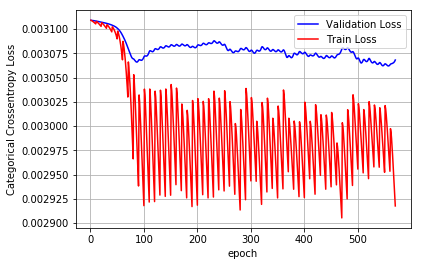

In [58]:
%time score = model.evaluate(X_test, Y_test, verbose=0) 
print('test score:', score[0]) 
print('test accuracy:', score[1])
    
model_pretty_table.add_row([model_name, round(score[0]*100,2), round(score[1]*100,2)])
    
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

#vy = history.history['val_loss']
#ty = history.history['loss']

vy = val_loss
ty = loss

plt_dynamic(fig, x, vy, ty, ax)

In [59]:
'''
## **3 Layer LSTM Model**
model_name = '3 Layer LSTM Model'
nb_epoch=12
batch_size=32
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
compile_execute_model()
'''

"\n## **3 Layer LSTM Model**\nmodel_name = '3 Layer LSTM Model'\nnb_epoch=12\nbatch_size=32\nembedding_vecor_length = 32\nmodel = Sequential()\nmodel.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))\nmodel.add(LSTM(100, return_sequences=True))\nmodel.add(LSTM(100, return_sequences=True))\nmodel.add(LSTM(100))\nmodel.add(Dense(1, activation='sigmoid'))\ncompile_execute_model()\n"

### Result

In [60]:
print(model_pretty_table)

+--------------------+------------+---------------+
|       Model        | Test Score | Test Accuracy |
+--------------------+------------+---------------+
| 1 Layer LSTM Model |    0.31    |     99.97     |
+--------------------+------------+---------------+
